In [1]:
# ==========================================
# 0. Imports & Device
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 재현성(선택)
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# ==========================================
# 1. Load Data (train + validation)
# ==========================================
train_seq = pd.read_csv('train_sequences.csv')
val_seq   = pd.read_csv('validation_sequences.csv')

# low_memory=False로 mixed dtype 경고 완화
train_labels = pd.read_csv('train_labels.csv', low_memory=False)
val_labels   = pd.read_csv('validation_labels.csv', low_memory=False)

print(f"Train seq shape: {train_seq.shape}")
print(f"Val   seq shape: {val_seq.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Val   labels shape: {val_labels.shape}")


Train seq shape: (5716, 8)
Val   seq shape: (28, 8)
Train labels shape: (7794971, 8)
Val   labels shape: (9762, 126)


In [3]:
# ==========================================
# 2. Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize(seq: str):
    return [mapping.get(b, 0) for b in str(seq)]

for df in (train_seq, val_seq):
    df['target_id'] = df['target_id'].astype(str).str.strip()
    df['tokenized'] = df['sequence'].apply(tokenize)

print("Tokenized train/val sequences.")


Tokenized train/val sequences.


In [4]:
# ==========================================
# 3. Label preprocessing (train + validation)
#    - train_labels: (x_1,y_1,z_1) 단일 구조
#    - val_labels: (x_1..z_40) 다중 슬롯 + 결측이 -1e18 같은 센티넬로 들어있음
#      => isfinite만으로는 결측을 못 걸러서 abs<threshold 조건을 추가
# ==========================================
XYZ = ['x_1','y_1','z_1']
ABS_THRESH = 1e17   # -1e18 같은 센티넬 결측 제거용
MIN_VALID_POINTS = 30  # 너무 결측이 많은 target 제거(안정성)

def _clean_base(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _clean_base(train_labels)

    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)

    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < ABS_THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)

    # 결측은 0으로 채우고 mask로 제외
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    # target 단위 유효 포인트 수 기준 필터
    valid_counts = df.groupby('target_id')['coord_ok'].sum()
    good_ids = valid_counts[valid_counts >= MIN_VALID_POINTS].index
    df = df[df['target_id'].isin(good_ids)].copy()

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df = (df.groupby('target_id')['coord_ok']
               .apply(lambda x: x.to_numpy(np.float32).tolist())
               .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _clean_base(val_labels)

    # 각 row(residue)마다 k=1..K 중 '처음으로 유효한' 좌표를 선택해 (x_1,y_1,z_1)에 저장
    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)

        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < ABS_THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'], df['y_1'], df['z_1'] = chosen[:,0], chosen[:,1], chosen[:,2]
    df['coord_ok'] = ok_mask

    # target 단위 유효 포인트 수 기준 필터
    valid_counts = df.groupby('target_id')['coord_ok'].sum()
    good_ids = valid_counts[valid_counts >= MIN_VALID_POINTS].index
    df = df[df['target_id'].isin(good_ids)].copy()

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df = (df.groupby('target_id')['coord_ok']
               .apply(lambda x: x.to_numpy(np.float32).tolist())
               .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

# key 정리
train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

# seq/coords 합치기
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_df = all_seq.merge(all_coords, on='target_id', how='inner')
print("all_df shape:", all_df.shape)

# max_len 창에서 유효 포인트가 너무 적으면 제거 (Kabsch 안정화)
MAX_LEN = 256
all_df['valid_in_window'] = all_df['coord_mask'].apply(
    lambda m: float(np.sum(np.asarray(m, dtype=np.float32)[:MAX_LEN]))
)
before = len(all_df)
all_df = all_df[all_df['valid_in_window'] >= 30].copy()
print(f"Filtered all_df by valid_in_window>=30: {before} -> {len(all_df)}")

# sanity: NaN/Inf check
def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())
print("NaN/Inf coords after cleaning:", all_df['coordinates'].apply(has_nan_inf).sum())


all_df shape: (4750, 11)
Filtered all_df by valid_in_window>=30: 4750 -> 4749
NaN/Inf coords after cleaning: 0


In [5]:
# ==========================================
# 4. Kabsch RMSD Loss (mask supported, and correct SVD handling)
# ==========================================
def kabsch_rotation(P, Q, mask=None):
    """
    P, Q: (B, N, 3)
    mask: (B, N)  1(valid), 0(invalid/pad)
    """
    if mask is None:
        mask = torch.ones(P.shape[0], P.shape[1], device=P.device, dtype=P.dtype)

    mask_exp = mask.unsqueeze(-1)  # (B,N,1)
    mask_sum = mask_exp.sum(dim=1, keepdim=True).clamp_min(1e-8)

    P_mean = (P * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    Q_mean = (Q * mask_exp).sum(dim=1, keepdim=True) / mask_sum

    P_c = (P - P_mean) * mask_exp
    Q_c = (Q - Q_mean) * mask_exp

    H = torch.matmul(P_c.transpose(1, 2), Q_c)  # (B,3,3)

    # torch.linalg.svd returns U,S,Vh
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    V = Vh.transpose(1, 2)

    det = torch.det(torch.matmul(V, U.transpose(1, 2)))
    sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

    E = torch.eye(3, device=P.device, dtype=P.dtype).unsqueeze(0).repeat(P.shape[0], 1, 1)
    E[:, 2, 2] = sign

    R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)
    P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean

    return P_aligned * mask_exp


class KabschRMSDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, target, mask):
        """
        preds : (B, K, N, 3)
        target: (B, N, 3)
        mask  : (B, N) 1(valid), 0(invalid/pad)
        """
        B, K, N, _ = preds.shape
        losses = []
        for k in range(K):
            pred_k = preds[:, k, :, :]
            pred_aligned = kabsch_rotation(pred_k, target, mask)

            diff_sq = (pred_aligned - target) ** 2
            sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
            n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)           # (B,)
            mse = sum_sq / n_valid
            rmsd = torch.sqrt(mse + 1e-8)
            losses.append(rmsd)

        losses = torch.stack(losses, dim=1)  # (B,K)
        min_loss, _ = torch.min(losses, dim=1)
        return torch.mean(min_loss)

In [6]:
# ==========================================
# 5. Dataset (uses coord_mask to ignore missing labels)
#    v4: 좌표 중심화 + 스케일 정규화(샘플별) 추가
# ==========================================
class RNADataset(Dataset):
    def __init__(self, sequences, coordinates, coord_masks, max_len=256):
        self.sequences = sequences
        self.coordinates = coordinates
        self.coord_masks = coord_masks
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        coords = np.asarray(self.coordinates[idx], dtype=np.float32)
        c_mask = np.asarray(self.coord_masks[idx], dtype=np.float32)

        # 안전하게 길이 맞추기
        L = min(len(seq), coords.shape[0], c_mask.shape[0], self.max_len)

        coords_L = coords[:L]
        mask_L = c_mask[:L]
        valid = mask_L > 0.5

        # ===== v4 핵심: 좌표 정규화(centering + scaling) =====
        if valid.sum() > 0:
            center = coords_L[valid].mean(axis=0, keepdims=True)
            coords_L = coords_L - center

            # RMS scale (valid points only)
            scale = np.sqrt((coords_L[valid] ** 2).sum(axis=1).mean())
            scale = max(float(scale), 1e-6)
            coords_L = coords_L / scale

        # seq padding
        seq_padded = np.zeros(self.max_len, dtype=np.int64)
        seq_padded[:L] = np.asarray(seq[:L], dtype=np.int64)

        # coords padding
        coords_padded = np.zeros((self.max_len, 3), dtype=np.float32)
        coords_padded[:L] = coords_L

        # 최종 mask: 라벨 유효(coord_ok)만 1 (패딩/결측은 0)
        mask = np.zeros(self.max_len, dtype=np.float32)
        mask[:L] = mask_L

        return (
            torch.tensor(seq_padded, dtype=torch.long),
            torch.tensor(coords_padded, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.float32),
        )


In [7]:
# ==========================================
# 6. Train/Holdout split & DataLoaders
#    - val을 학습 데이터로 포함했으므로, 별도 holdout을 만든다
# ==========================================
train_idx, val_idx = train_test_split(range(len(all_df)), test_size=0.1, random_state=42)

train_df = all_df.iloc[train_idx].reset_index(drop=True)
hold_df  = all_df.iloc[val_idx].reset_index(drop=True)

print("train_df:", train_df.shape, "hold_df:", hold_df.shape)

train_dataset = RNADataset(
    train_df['tokenized'].values,
    train_df['coordinates'].values,
    train_df['coord_mask'].values,
    max_len=256
)
val_dataset = RNADataset(
    hold_df['tokenized'].values,
    hold_df['coordinates'].values,
    hold_df['coord_mask'].values,
    max_len=256
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


train_df: (4274, 12) hold_df: (475, 12)


In [8]:
# ==========================================
# 7. Model (Transformer + padding mask for attention)
# ==========================================
class RNATransformer(nn.Module):
    def __init__(self, n_tokens=5, d_model=256, nhead=8, num_layers=6, dropout=0.1, num_preds=5):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.num_preds = num_preds
        self.fc_coords = nn.Linear(d_model, 3 * num_preds)

    def forward(self, tokens):
        # tokens: (B,T)
        B, T = tokens.shape
        padding_mask = (tokens == 0)  # True at PAD positions

        x = self.embedding(tokens)
        x = x + self.pos_encoder[:, :T, :]
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)

        out = self.fc_coords(x)  # (B,T,3*K)
        out = out.view(B, T, self.num_preds, 3).permute(0, 2, 1, 3)  # (B,K,T,3)
        return out

model = RNATransformer(d_model=256, nhead=8, num_layers=6, num_preds=5).to(device)
print("Model Initialized (Best-of-5 Output Strategy).")


Model Initialized (Best-of-5 Output Strategy).


In [9]:
## ==========================================
# 8. Train v3: 2-Stage Loss (Masked L1 warmup -> Kabsch), LR Scheduler, Early Stopping
# ==========================================
import math

def masked_l1_loss(preds, target, mask):
    """
    preds : (B, K, T, 3)
    target: (B, T, 3)
    mask  : (B, T) 1(valid), 0(invalid/pad)

    Best-of-K: pick the minimum loss among K predictions.
    """
    B, K, T, C = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)

    losses = []
    for k in range(K):
        pk = preds[:, k]  # (B,T,3)
        diff = (pk - target).abs() * m
        denom = m.sum(dim=(1,2)).clamp_min(1.0)   # (B,)
        l1 = diff.sum(dim=(1,2)) / denom          # (B,)
        losses.append(l1)

    losses = torch.stack(losses, dim=1)  # (B,K)
    min_loss, _ = torch.min(losses, dim=1)
    return min_loss.mean()


# ---- Config ----
epochs = 60
warmup_epochs = 5           # first 5 epochs use masked L1, then switch to Kabsch
patience = 7
min_delta = 1e-4
best_path = "best_v3.pt"

# Optimizer (stable default for this setup)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)

# LR scheduler: warmup + cosine decay (step-based)
total_steps = epochs * len(train_loader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Criterion for stage 2
criterion = KabschRMSDLoss()

# Early stopping state
best_val = float("inf")
stale = 0
global_step = 0

print(f"Starting v3 training: epochs={epochs}, warmup_epochs={warmup_epochs}, patience={patience}")

for epoch in range(epochs):
    use_kabsch = (epoch >= warmup_epochs)
    stage = "KABSCH" if use_kabsch else "MASKED_L1"

    # =========================
    # Train
    # =========================
    model.train()
    train_loss_sum = 0.0
    train_steps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [{stage}]")
    for seq, target, mask in pbar:
        seq = seq.to(device)
        target = target.to(device)
        mask = mask.to(device)

        # Filter samples with too few valid points inside the training window
        valid_counts = mask.sum(dim=1)  # (B,)
        keep = valid_counts >= 20       # 안정 마진 (필요하면 10/30으로 조절)

        if keep.sum() < 2:
            continue

        seq = seq[keep]
        target = target[keep]
        mask = mask[keep]

        optimizer.zero_grad(set_to_none=True)

        preds = model(seq)  # (B,K,T,3)

        if use_kabsch:
            loss = criterion(preds, target, mask)
        else:
            loss = masked_l1_loss(preds, target, mask)

        if not torch.isfinite(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        scheduler.step()
        global_step += 1

        train_loss_sum += loss.item()
        train_steps += 1

        lr_now = optimizer.param_groups[0]["lr"]
        pbar.set_postfix({"loss": float(loss.item()), "lr": lr_now, "kept": int(keep.sum())})

    avg_train = train_loss_sum / max(1, train_steps)

    # =========================
    # Validation
    # =========================
    model.eval()
    val_loss_sum = 0.0
    val_steps = 0

    with torch.no_grad():
        for seq, target, mask in val_loader:
            seq = seq.to(device)
            target = target.to(device)
            mask = mask.to(device)

            valid_counts = mask.sum(dim=1)
            keep = valid_counts >= 20
            if keep.sum() < 2:
                continue

            seq = seq[keep]
            target = target[keep]
            mask = mask[keep]

            preds = model(seq)

            if use_kabsch:
                loss = criterion(preds, target, mask)
            else:
                loss = masked_l1_loss(preds, target, mask)

            if not torch.isfinite(loss):
                continue

            val_loss_sum += loss.item()
            val_steps += 1

    avg_val = val_loss_sum / max(1, val_steps)
    print(f"[Epoch {epoch+1:02d}] stage={stage:9s}  train={avg_train:.6f}  val={avg_val:.6f}  steps(train/val)={train_steps}/{val_steps}")

    # =========================
    # Early stopping (only enforce after warmup)
    # =========================
    if avg_val < best_val - min_delta:
        best_val = avg_val
        stale = 0
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best saved: val={best_val:.6f}")
    else:
        stale += 1
        print(f"⏸ No improvement: {stale}/{patience}")
        if epoch >= warmup_epochs and stale >= patience:
            print("🛑 Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load(best_path, map_location=device))
print(f"✅ Best model loaded from {best_path} (best val={best_val:.6f})")


Starting v3 training: epochs=60, warmup_epochs=5, patience=7


Epoch 1/60 [MASKED_L1]: 100%|██████████| 267/267 [00:18<00:00, 14.31it/s, loss=1.39, lr=1e-5, kept=16]   
c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


[Epoch 01] stage=MASKED_L1  train=1.424753  val=1.388575  steps(train/val)=267/30
✅ New best saved: val=1.388575


Epoch 2/60 [MASKED_L1]: 100%|██████████| 267/267 [00:18<00:00, 14.24it/s, loss=1.4, lr=2e-5, kept=16]    


[Epoch 02] stage=MASKED_L1  train=1.400454  val=1.386899  steps(train/val)=267/30
✅ New best saved: val=1.386899


Epoch 3/60 [MASKED_L1]: 100%|██████████| 267/267 [00:18<00:00, 14.25it/s, loss=1.4, lr=3e-5, kept=16]    


[Epoch 03] stage=MASKED_L1  train=1.398264  val=1.387568  steps(train/val)=267/30
⏸ No improvement: 1/7


Epoch 4/60 [MASKED_L1]: 100%|██████████| 267/267 [00:18<00:00, 14.09it/s, loss=1.38, lr=3e-5, kept=16]


[Epoch 04] stage=MASKED_L1  train=1.395314  val=1.387420  steps(train/val)=267/30
⏸ No improvement: 2/7


Epoch 5/60 [MASKED_L1]: 100%|██████████| 267/267 [00:18<00:00, 14.14it/s, loss=1.39, lr=2.99e-5, kept=16]


[Epoch 05] stage=MASKED_L1  train=1.393099  val=1.387164  steps(train/val)=267/30
⏸ No improvement: 3/7


Epoch 6/60 [KABSCH]: 100%|██████████| 267/267 [00:17<00:00, 15.07it/s, loss=0.572, lr=2.98e-5, kept=16]


[Epoch 06] stage=KABSCH     train=0.569852  val=0.572935  steps(train/val)=267/30
✅ New best saved: val=0.572935


Epoch 7/60 [KABSCH]: 100%|██████████| 267/267 [00:20<00:00, 13.04it/s, loss=0.572, lr=2.96e-5, kept=16]


[Epoch 07] stage=KABSCH     train=0.569618  val=0.572992  steps(train/val)=267/30
⏸ No improvement: 1/7


Epoch 8/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.34it/s, loss=0.568, lr=2.94e-5, kept=16]


[Epoch 08] stage=KABSCH     train=0.569725  val=0.572980  steps(train/val)=267/30
⏸ No improvement: 2/7


Epoch 9/60 [KABSCH]: 100%|██████████| 267/267 [02:09<00:00,  2.06it/s, loss=0.572, lr=2.92e-5, kept=16]


[Epoch 09] stage=KABSCH     train=0.569595  val=0.573061  steps(train/val)=267/30
⏸ No improvement: 3/7


Epoch 10/60 [KABSCH]: 100%|██████████| 267/267 [00:25<00:00, 10.29it/s, loss=0.571, lr=2.89e-5, kept=16]


[Epoch 10] stage=KABSCH     train=0.569493  val=0.573041  steps(train/val)=267/30
⏸ No improvement: 4/7


Epoch 11/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s, loss=0.571, lr=2.86e-5, kept=16]


[Epoch 11] stage=KABSCH     train=0.569441  val=0.573009  steps(train/val)=267/30
⏸ No improvement: 5/7


Epoch 12/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s, loss=0.568, lr=2.82e-5, kept=16]


[Epoch 12] stage=KABSCH     train=0.569430  val=0.572885  steps(train/val)=267/30
⏸ No improvement: 6/7


Epoch 13/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.36it/s, loss=0.572, lr=2.78e-5, kept=16]


[Epoch 13] stage=KABSCH     train=0.569554  val=0.572814  steps(train/val)=267/30
✅ New best saved: val=0.572814


Epoch 14/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.33it/s, loss=0.571, lr=2.73e-5, kept=16]


[Epoch 14] stage=KABSCH     train=0.569428  val=0.572721  steps(train/val)=267/30
⏸ No improvement: 1/7


Epoch 15/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.51it/s, loss=0.568, lr=2.68e-5, kept=16]


[Epoch 15] stage=KABSCH     train=0.569342  val=0.572552  steps(train/val)=267/30
✅ New best saved: val=0.572552


Epoch 16/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s, loss=0.569, lr=2.63e-5, kept=16]


[Epoch 16] stage=KABSCH     train=0.569303  val=0.572106  steps(train/val)=267/30
✅ New best saved: val=0.572106


Epoch 17/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.49it/s, loss=0.511, lr=2.58e-5, kept=16]


[Epoch 17] stage=KABSCH     train=0.556498  val=0.505506  steps(train/val)=267/30
✅ New best saved: val=0.505506


Epoch 18/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.43it/s, loss=0.502, lr=2.52e-5, kept=16]


[Epoch 18] stage=KABSCH     train=0.502798  val=0.476666  steps(train/val)=267/30
✅ New best saved: val=0.476666


Epoch 19/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.41it/s, loss=0.45, lr=2.45e-5, kept=16] 


[Epoch 19] stage=KABSCH     train=0.466128  val=0.409498  steps(train/val)=267/30
✅ New best saved: val=0.409498


Epoch 20/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s, loss=0.369, lr=2.39e-5, kept=16]


[Epoch 20] stage=KABSCH     train=0.413925  val=0.378759  steps(train/val)=267/30
✅ New best saved: val=0.378759


Epoch 21/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.42it/s, loss=0.404, lr=2.32e-5, kept=16]


[Epoch 21] stage=KABSCH     train=0.391949  val=0.368533  steps(train/val)=267/30
✅ New best saved: val=0.368533


Epoch 22/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.51it/s, loss=0.399, lr=2.25e-5, kept=16]


[Epoch 22] stage=KABSCH     train=0.381146  val=0.361030  steps(train/val)=267/30
✅ New best saved: val=0.361030


Epoch 23/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.19it/s, loss=0.33, lr=2.18e-5, kept=16] 


[Epoch 23] stage=KABSCH     train=0.371815  val=0.350354  steps(train/val)=267/30
✅ New best saved: val=0.350354


Epoch 24/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s, loss=0.362, lr=2.1e-5, kept=16] 


[Epoch 24] stage=KABSCH     train=0.360517  val=0.339962  steps(train/val)=267/30
✅ New best saved: val=0.339962


Epoch 25/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.29it/s, loss=0.316, lr=2.03e-5, kept=16]


[Epoch 25] stage=KABSCH     train=0.352918  val=0.333807  steps(train/val)=267/30
✅ New best saved: val=0.333807


Epoch 26/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s, loss=0.366, lr=1.95e-5, kept=16]


[Epoch 26] stage=KABSCH     train=0.347404  val=0.331732  steps(train/val)=267/30
✅ New best saved: val=0.331732


Epoch 27/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s, loss=0.336, lr=1.87e-5, kept=16]


[Epoch 27] stage=KABSCH     train=0.342500  val=0.323887  steps(train/val)=267/30
✅ New best saved: val=0.323887


Epoch 28/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s, loss=0.348, lr=1.79e-5, kept=16]


[Epoch 28] stage=KABSCH     train=0.337648  val=0.322970  steps(train/val)=267/30
✅ New best saved: val=0.322970


Epoch 29/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s, loss=0.372, lr=1.71e-5, kept=16]


[Epoch 29] stage=KABSCH     train=0.333837  val=0.317980  steps(train/val)=267/30
✅ New best saved: val=0.317980


Epoch 30/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.32it/s, loss=0.378, lr=1.62e-5, kept=16]


[Epoch 30] stage=KABSCH     train=0.330270  val=0.314207  steps(train/val)=267/30
✅ New best saved: val=0.314207


Epoch 31/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.41it/s, loss=0.317, lr=1.54e-5, kept=16]


[Epoch 31] stage=KABSCH     train=0.327566  val=0.310415  steps(train/val)=267/30
✅ New best saved: val=0.310415


Epoch 32/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.40it/s, loss=0.295, lr=1.46e-5, kept=16]


[Epoch 32] stage=KABSCH     train=0.324552  val=0.308472  steps(train/val)=267/30
✅ New best saved: val=0.308472


Epoch 33/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.43it/s, loss=0.273, lr=1.38e-5, kept=16]


[Epoch 33] stage=KABSCH     train=0.322359  val=0.305561  steps(train/val)=267/30
✅ New best saved: val=0.305561


Epoch 34/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.20it/s, loss=0.323, lr=1.29e-5, kept=16]


[Epoch 34] stage=KABSCH     train=0.319935  val=0.304461  steps(train/val)=267/30
✅ New best saved: val=0.304461


Epoch 35/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.46it/s, loss=0.256, lr=1.21e-5, kept=16]


[Epoch 35] stage=KABSCH     train=0.317764  val=0.303284  steps(train/val)=267/30
✅ New best saved: val=0.303284


Epoch 36/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s, loss=0.354, lr=1.13e-5, kept=16]


[Epoch 36] stage=KABSCH     train=0.316305  val=0.301011  steps(train/val)=267/30
✅ New best saved: val=0.301011


Epoch 37/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.38it/s, loss=0.263, lr=1.05e-5, kept=16]


[Epoch 37] stage=KABSCH     train=0.314469  val=0.299635  steps(train/val)=267/30
✅ New best saved: val=0.299635


Epoch 38/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.44it/s, loss=0.328, lr=9.74e-6, kept=16]


[Epoch 38] stage=KABSCH     train=0.313016  val=0.298437  steps(train/val)=267/30
✅ New best saved: val=0.298437


Epoch 39/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.29it/s, loss=0.288, lr=8.97e-6, kept=16]


[Epoch 39] stage=KABSCH     train=0.311815  val=0.297895  steps(train/val)=267/30
✅ New best saved: val=0.297895


Epoch 40/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.38it/s, loss=0.327, lr=8.23e-6, kept=16]


[Epoch 40] stage=KABSCH     train=0.310381  val=0.295948  steps(train/val)=267/30
✅ New best saved: val=0.295948


Epoch 41/60 [KABSCH]: 100%|██████████| 267/267 [00:23<00:00, 11.37it/s, loss=0.297, lr=7.5e-6, kept=16] 


[Epoch 41] stage=KABSCH     train=0.309254  val=0.295326  steps(train/val)=267/30
✅ New best saved: val=0.295326


Epoch 42/60 [KABSCH]: 100%|██████████| 267/267 [00:21<00:00, 12.24it/s, loss=0.301, lr=6.8e-6, kept=16] 


[Epoch 42] stage=KABSCH     train=0.308228  val=0.295069  steps(train/val)=267/30
✅ New best saved: val=0.295069


Epoch 43/60 [KABSCH]: 100%|██████████| 267/267 [00:19<00:00, 14.05it/s, loss=0.303, lr=6.12e-6, kept=16]


[Epoch 43] stage=KABSCH     train=0.307473  val=0.293806  steps(train/val)=267/30
✅ New best saved: val=0.293806


Epoch 44/60 [KABSCH]: 100%|██████████| 267/267 [00:21<00:00, 12.49it/s, loss=0.319, lr=5.46e-6, kept=16]


[Epoch 44] stage=KABSCH     train=0.306371  val=0.293831  steps(train/val)=267/30
⏸ No improvement: 1/7


Epoch 45/60 [KABSCH]: 100%|██████████| 267/267 [01:53<00:00,  2.35it/s, loss=0.269, lr=4.84e-6, kept=16]


[Epoch 45] stage=KABSCH     train=0.305711  val=0.294061  steps(train/val)=267/30
⏸ No improvement: 2/7


Epoch 46/60 [KABSCH]: 100%|██████████| 267/267 [00:59<00:00,  4.52it/s, loss=0.325, lr=4.25e-6, kept=16]


[Epoch 46] stage=KABSCH     train=0.305130  val=0.292768  steps(train/val)=267/30
✅ New best saved: val=0.292768


Epoch 47/60 [KABSCH]: 100%|██████████| 267/267 [00:35<00:00,  7.43it/s, loss=0.289, lr=3.69e-6, kept=16]


[Epoch 47] stage=KABSCH     train=0.304332  val=0.291834  steps(train/val)=267/30
✅ New best saved: val=0.291834


Epoch 48/60 [KABSCH]: 100%|██████████| 267/267 [00:47<00:00,  5.61it/s, loss=0.36, lr=3.16e-6, kept=16] 


[Epoch 48] stage=KABSCH     train=0.303847  val=0.291242  steps(train/val)=267/30
✅ New best saved: val=0.291242


Epoch 49/60 [KABSCH]: 100%|██████████| 267/267 [00:35<00:00,  7.48it/s, loss=0.287, lr=2.67e-6, kept=16]


[Epoch 49] stage=KABSCH     train=0.303552  val=0.290863  steps(train/val)=267/30
✅ New best saved: val=0.290863


Epoch 50/60 [KABSCH]: 100%|██████████| 267/267 [00:35<00:00,  7.51it/s, loss=0.286, lr=2.22e-6, kept=16]


[Epoch 50] stage=KABSCH     train=0.302952  val=0.290528  steps(train/val)=267/30
✅ New best saved: val=0.290528


Epoch 51/60 [KABSCH]: 100%|██████████| 267/267 [00:58<00:00,  4.56it/s, loss=0.283, lr=1.81e-6, kept=16]


[Epoch 51] stage=KABSCH     train=0.302699  val=0.290391  steps(train/val)=267/30
✅ New best saved: val=0.290391


Epoch 52/60 [KABSCH]: 100%|██████████| 267/267 [00:47<00:00,  5.66it/s, loss=0.29, lr=1.43e-6, kept=16] 


[Epoch 52] stage=KABSCH     train=0.302588  val=0.290101  steps(train/val)=267/30
✅ New best saved: val=0.290101


Epoch 53/60 [KABSCH]: 100%|██████████| 267/267 [00:35<00:00,  7.44it/s, loss=0.276, lr=1.1e-6, kept=16] 


[Epoch 53] stage=KABSCH     train=0.302159  val=0.289797  steps(train/val)=267/30
✅ New best saved: val=0.289797


Epoch 54/60 [KABSCH]: 100%|██████████| 267/267 [00:41<00:00,  6.38it/s, loss=0.314, lr=8.13e-7, kept=16]


[Epoch 54] stage=KABSCH     train=0.301940  val=0.290194  steps(train/val)=267/30
⏸ No improvement: 1/7


Epoch 55/60 [KABSCH]: 100%|██████████| 267/267 [00:27<00:00,  9.78it/s, loss=0.322, lr=5.66e-7, kept=16]


[Epoch 55] stage=KABSCH     train=0.301900  val=0.289955  steps(train/val)=267/30
⏸ No improvement: 2/7


Epoch 56/60 [KABSCH]: 100%|██████████| 267/267 [00:24<00:00, 10.96it/s, loss=0.29, lr=3.63e-7, kept=16] 


[Epoch 56] stage=KABSCH     train=0.301894  val=0.289870  steps(train/val)=267/30
⏸ No improvement: 3/7


Epoch 57/60 [KABSCH]: 100%|██████████| 267/267 [00:36<00:00,  7.40it/s, loss=0.275, lr=2.05e-7, kept=16]


[Epoch 57] stage=KABSCH     train=0.301681  val=0.289603  steps(train/val)=267/30
✅ New best saved: val=0.289603


Epoch 58/60 [KABSCH]: 100%|██████████| 267/267 [00:24<00:00, 10.97it/s, loss=0.289, lr=9.1e-8, kept=16] 


[Epoch 58] stage=KABSCH     train=0.301709  val=0.289582  steps(train/val)=267/30
⏸ No improvement: 1/7


Epoch 59/60 [KABSCH]: 100%|██████████| 267/267 [01:10<00:00,  3.76it/s, loss=0.293, lr=2.28e-8, kept=16]


[Epoch 59] stage=KABSCH     train=0.301431  val=0.289548  steps(train/val)=267/30
⏸ No improvement: 2/7


Epoch 60/60 [KABSCH]: 100%|██████████| 267/267 [00:48<00:00,  5.56it/s, loss=0.325, lr=0, kept=16]       


[Epoch 60] stage=KABSCH     train=0.301664  val=0.289550  steps(train/val)=267/30
⏸ No improvement: 3/7
✅ Best model loaded from best_v3.pt (best val=0.289603)


In [10]:
# ==========================================
# 10. Visualization (uses mask correctly)
# ==========================================
seq_batch, target_batch, mask_batch = next(iter(val_loader))
seq_batch = seq_batch.to(device)
target_batch = target_batch.to(device)
mask_batch = mask_batch.to(device)

with torch.no_grad():
    pred_batch = model(seq_batch)  # (B,5,T,3)

mask0 = mask_batch[0].detach().cpu().numpy().astype(bool)
t0 = target_batch[0].detach().cpu().numpy()[mask0]     # (L_valid,3)
p0 = pred_batch[0, 0].detach().cpu().numpy()[mask0]    # pred k=0

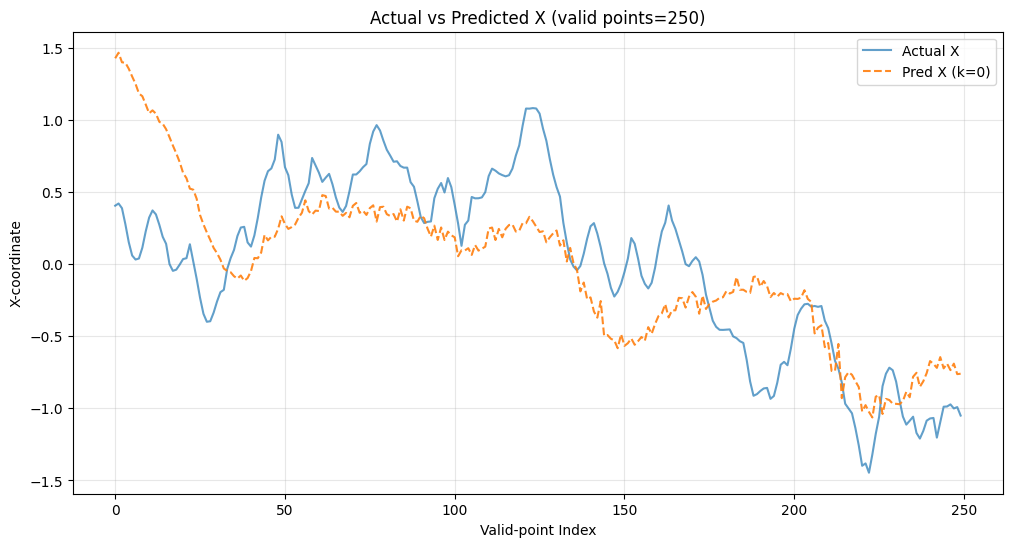

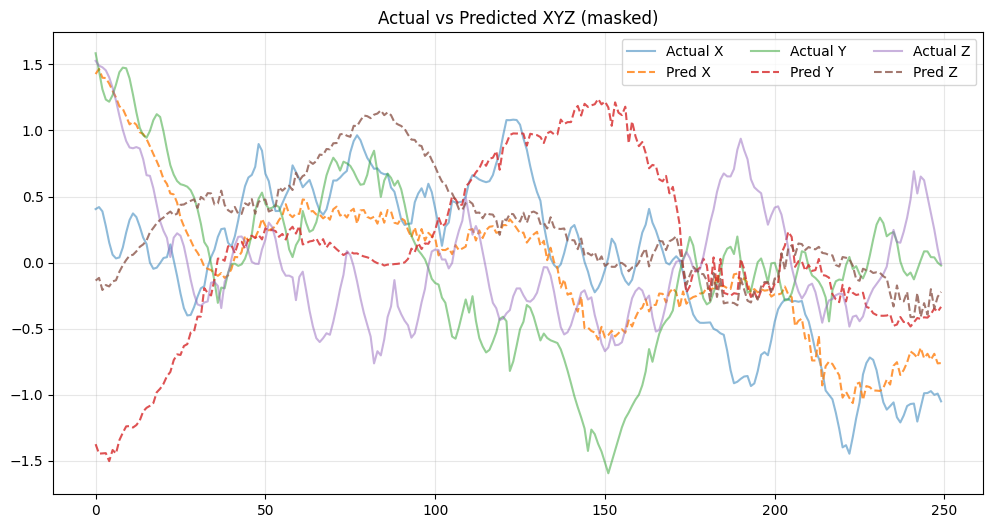

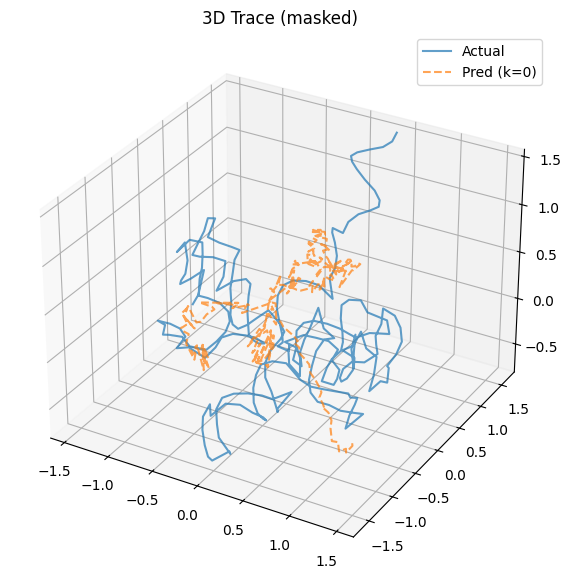

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(t0[:, 0], label="Actual X", alpha=0.7)
plt.plot(p0[:, 0], label="Pred X (k=0)", linestyle="--", alpha=0.9)
plt.title(f"Actual vs Predicted X (valid points={mask0.sum()})")
plt.xlabel("Valid-point Index")
plt.ylabel("X-coordinate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
for i, name in enumerate(["X", "Y", "Z"]):
    plt.plot(t0[:, i], label=f"Actual {name}", alpha=0.5)
    plt.plot(p0[:, i], label=f"Pred {name}", linestyle="--", alpha=0.8)
plt.title("Actual vs Predicted XYZ (masked)")
plt.legend(ncol=3)
plt.grid(alpha=0.3)
plt.show()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(t0[:, 0], t0[:, 1], t0[:, 2], label="Actual", alpha=0.7)
ax.plot(p0[:, 0], p0[:, 1], p0[:, 2], label="Pred (k=0)", alpha=0.7, linestyle="--")
ax.set_title("3D Trace (masked)")
ax.legend()
plt.show()
